Arkadijs Slobodkins
Final Project

In [1]:
from keras import models
import keras.backend as K
from keras import layers
from keras import models
from keras import optimizers
from keras.layers import Dense
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras import initializers
import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import random
from decimal import Decimal

Cells below contain training data generators, validation data generators, functions to test data, and models designed specifically for training certain types of problems. 

In [2]:
#1:Generate intervals so that left points are always = low_bound and right points are in (low_bound, up_bound]. Data points 
#are generated and stored in the form (low_bound, yi).

def IntervalsZero(points, grid):
    numIntervals = points - 1
    Intervals  = np.zeros([numIntervals, 2])
    FInterval = np.zeros(numIntervals)
    for i in range(numIntervals):
        Intervals[i, 0] = grid[0]
        Intervals[i, 1] = grid[i+1]
    
    for i in range(numIntervals):
        FInterval[i] = np.exp(grid[i+1]) - np.exp(grid[0])
    return Intervals, FInterval

In [3]:
#1:Generate intervals so that left points are always = low_bound and right points are in (low_bound, up_bouns]. Data points 
#are generated and stored in the form yi, discarding x coordinate x = low_bound. 

def IntervalsZeroPoint(points, grid):
    numIntervals = points - 1
    Intervals  = np.zeros([numIntervals, 1])
    FInterval = np.zeros(numIntervals)
    for i in range(numIntervals):
        Intervals[i, 0] = grid[i+1]
    
    for i in range(numIntervals):
        FInterval[i] = np.exp(grid[i+1]) - np.exp(grid[0])
    return Intervals, FInterval

In [4]:
#3. Generate evenly spaced intervals of equal size and store both coordinates. 

def IntervalsRandomEven(numIntervals, width, low_bound, up_bound):
   
    Intervals  = np.zeros([numIntervals, 2])
    FInterval = np.zeros(numIntervals)
    stepSize = (up_bound - low_bound)/numIntervals
    for i in range(numIntervals):
        #Intervals[i, 0] = random.uniform(0.0, 1.0-1.2*width)
        #Intervals[i, 1] = Intervals[i,0] + width*(1+ random.uniform(0.0, 0.2))
        Intervals[i,0] = low_bound + i*stepSize
        Intervals[i, 1] = Intervals[i,0] + width#*(1+ random.uniform(-0.1, 0.1))
    for i in range(numIntervals):
        FInterval[i] = np.exp(Intervals[i,1]) - np.exp(Intervals[i,0])
    return Intervals, FInterval


#3. Generate evenly spaced intervals of equal size and store both coordinates. 

def IntervalsRandomEvenPolynomial(numIntervals, width, low_bound, up_bound, power):
   
    Intervals  = np.zeros([numIntervals, 2])
    FInterval = np.zeros(numIntervals)
    stepSize = (up_bound - low_bound)/numIntervals
    for i in range(numIntervals):
        #Intervals[i, 0] = random.uniform(0.0, 1.0-1.2*width)
        #Intervals[i, 1] = Intervals[i,0] + width*(1+ random.uniform(0.0, 0.2))
        Intervals[i,0] = low_bound + i*stepSize
        Intervals[i, 1] = Intervals[i,0] + width#*(1+ random.uniform(-0.1, 0.1))
    for i in range(numIntervals):
        FInterval[i] = ((Intervals[i,1])**(power+1) - (Intervals[i,0])**(power+1))/(power+1) 
    return Intervals, FInterval

In [5]:
#4. Generate all possible combinations of the grid points on the interval [low_bound, up_bound].

def IntervalsRandom(points, grid):
    numIntervals = int((points - 1)*points/2)
    Intervals  = np.zeros([numIntervals, 2])
    FInterval = np.zeros(numIntervals)
    count = 0
    for i in range(points):
        for j in range(i+1, points):
            Intervals[count, 0] = grid[i]
            Intervals[count, 1] = grid[j]
            count += 1
    for i in range(numIntervals):
        FInterval[i] = np.exp(Intervals[i, 1]) - np.exp(Intervals[i,0])
    return Intervals, FInterval

In [6]:
#custom loss function is based on template 
#https://towardsdatascience.com/how-to-create-a-custom-loss-function-keras-3a89156ec69b

def Integral_loss(y_true, y_pred):
    L2 = K.sum(abs((y_pred-y_true))**2)
    loss =  K.sqrt(L2)/points
    return loss

In [21]:
#Model for training dataset where x coordinate is always = low_bound
#and input vector is of length 2.

def TrainModelPolynomial(Intervals, FInterval):
    model = models.Sequential() 
    model.add(layers.Dense(64,  kernel_initializer='normal', activation = 'relu',  input_shape=(2, )))
    model.add(layers.Dense(64,  kernel_initializer='normal', activation = 'relu', ))

    model.add(Dense(1))
    
    opt = optimizers.Adam(learning_rate=0.00008)
    model.compile(loss= Integral_loss, optimizer= opt)
    model.fit(Intervals, FInterval, batch_size = 32,  epochs = 50)
    return model

In [8]:
#Model for training dataset where x coordinate is always = low_bound
#and input vector is of length 2.

def TrainModelZero(Intervals, FInterval, x_val, y_val):
    model = models.Sequential() 
    model.add(layers.Dense(64,  kernel_initializer='normal', activation = 'relu',  input_shape=(2, )))
    model.add(layers.Dense(64,  kernel_initializer='normal', activation = 'relu', ))
    model.add(Dense(1))
    opt = optimizers.Adam(learning_rate=0.00005)
    model.compile(loss= Integral_loss, optimizer= opt)
    model.fit(Intervals, FInterval, batch_size = 32,  epochs = 75, validation_data = (x_val, y_val))
    return model

In [9]:
#Model for training dataset where x coordinate is always = low_bound
#and input vector is of length 1.

def TrainModelZeroPoint(Intervals, FInterval):
    model = models.Sequential() 
    model.add(layers.Dense(64,  kernel_initializer='normal', activation = 'relu',  input_shape=(1, )))
    model.add(Dense(1))
    opt = optimizers.Adam(learning_rate=0.00008)
    model.compile(loss= Integral_loss, optimizer=opt)
    model.fit(Intervals, FInterval, batch_size = 32,  epochs = 75)
    return model

In [10]:
#Model for training larger dataset on the interval [low_bound, up_bound].

def TrainModelArbitrary(Intervals, FInterval, x_val, y_val):
    model = models.Sequential() 
    model.add(layers.Dense(128,  kernel_initializer='normal', activation = 'relu',  input_shape=(2, )))
    model.add(layers.Dense(64,  kernel_initializer='normal', activation = 'relu', ))
    model.add(Dense(1))
    opt = optimizers.Adam(learning_rate=0.00008)
    model.compile(loss= Integral_loss, optimizer=opt)
    model.fit(Intervals, FInterval, batch_size = 32,  epochs = 30, validation_data = (x_val, y_val))
    return model

In [11]:
def TrainModelZeroRecurrent(Intervals, FInterval, x_val, y_val):
    
    model = models.Sequential()
    model.add(LSTM(64, input_shape=(1, 2)))
    model.add(layers.Dense(64,  kernel_initializer='normal', activation = 'relu', ))
    model.add(Dense(1))
    opt = optimizers.Adam(learning_rate=0.00008)
    model.compile(loss= Integral_loss, optimizer=opt)

    model.fit(Intervals, FInterval, epochs=20, batch_size=32, validation_data = (x_val, y_val))
    return model

In [12]:
#Test on random intervals on the interval [low_bound, up_bound], 
#where x is always = low_bound and y is random on the interval 
#(low_bound + minWidth, up_bound).

def TestModelZero(points, low_bound, up_bound, model, x_val, y_val):
    import random
    IntervalTest = np.zeros([1000,2])
    FTest = np.zeros(1000)
    relError = np.zeros(1000)
    i = 0
    min_width = (up_bound - low_bound) / points

    while(i<1000):
        x1 = low_bound
        x2 = random.uniform(low_bound + 10*min_width,up_bound)
    
        IntervalTest[i,0] = x1
        IntervalTest[i,1] = x2

        FTest[i] = ( np.exp(x2) - np.exp(x1) )
        i += 1

    Predicted = model.predict(IntervalTest, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 

    return relError, IntervalTest, FTest

In [13]:
#Test on random intervals of even length on the interval [low_bound,up_bound].
def TestModelZeroPoint(points, low_bound, up_bound, model):
    import random
    IntervalTest = np.zeros([1000,1])
    FTest = np.zeros(1000)
    relError = np.zeros(1000)
    i = 0
    minWidth = (up_bound - low_bound) / points

    while(i<1000):
        
        x = random.uniform(low_bound + 10*minWidth,up_bound)
        IntervalTest[i] = x

        FTest[i] = ( np.exp(x) - np.exp(0) )
        i += 1

    Predicted = model.predict(IntervalTest, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 

    return relError, IntervalTest, FTest

In [14]:
#test on random intervals of fixed  length on the interval [low_bound, up_bound]
def TestModelFixed(width, low_bound, up_bound, model):

    IntervalTest = np.zeros([1000,2])
    FTest = np.zeros(1000)
    relError = np.zeros(1000)
    i = 0
   
    while(i<1000):
        x1 = random.uniform(low_bound, up_bound) #- 1.2*width) 
        x2 = x1 + width#*(1+random.uniform(-0.1, 0.1))
    
        IntervalTest[i,0] = x1
        IntervalTest[i,1] = x2

        FTest[i] = ( np.exp(IntervalTest[i,1]) - np.exp(IntervalTest[i,0]) )
        i += 1
    Predicted = model.predict(IntervalTest, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 

    return relError, IntervalTest, FTest

#test on random intervals of fixed  length on the interval [low_bound, up_bound]
def TestModelFixedPolynomial(width, low_bound, up_bound, power, model):

    IntervalTest = np.zeros([1000,2])
    FTest = np.zeros(1000)
    relError = np.zeros(1000)
    absError = np.zeros(1000)
    i = 0
   
    while(i<1000):
        x1 = random.uniform(low_bound, up_bound-width) #- 1.2*width) 
        x2 = x1 + width#*(1+random.uniform(-0.1, 0.1))
    
        IntervalTest[i,0] = x1
        IntervalTest[i,1] = x2

        FTest[i] = ( (IntervalTest[i,1])**(power+1) - (IntervalTest[i,0])**(power+1) )/(power+1) 
        i += 1
    Predicted = model.predict(IntervalTest, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) /  abs(FTest[i])  
        absError[i] =  abs(Predicted[i] - FTest[i])
    return relError, IntervalTest, FTest, absError

In [15]:
#test on random intervals on the interval [low_bound, up_bound]
def TestModelArbitrary(points, low_bound, up_bound, model):
    import random
    IntervalTest = np.zeros([1000,2])
    FTest = np.zeros(1000)
    relError = np.zeros(1000)
    i = 0
    minWidth = (up_bound - low_bound) / points

    while(i<1000):
        x11 = random.uniform(low_bound, up_bound - minWidth)
        x12 = random.uniform(low_bound,up_bound)
        x1 = min(x11,x12)
        x2 = max(x11,x12)
        if( (abs(x2-x1) < 10*minWidth)):
            continue
        IntervalTest[i,0] = x1
        IntervalTest[i,1] = x2

        FTest[i] = ( np.exp(x2) - np.exp(x1) )
        i += 1

    Predicted = model.predict(IntervalTest, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 
    
    return relError, IntervalTest, FTest


#test on random intervals of fixed length on the interval [low_bound, up_bound]
def TestModelManyEvenly(points, low_bound, up_bound, model):
    import random
    IntervalTest = np.zeros([1000,2])
    FTest = np.zeros(1000)
    relError = np.zeros(1000)
    i = 0
    minWidth = (up_bound - low_bound) / (points - 1)

    while(i<100):
        x1 = random.uniform(low_bound, up_bound - 50*minWidth)
        x2 = x1 + 50*minWidth
      
        IntervalTest[i,0] = x1
        IntervalTest[i,1] = x2

        FTest[i] = ( np.exp(x2) - np.exp(x1) )
        i += 1

    Predicted = model.predict(IntervalTest, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 

    return relError, IntervalTest, FTest

#test on random intervals on the interval [low_bound, up_bound]
def TestModelRecurrentRandom(points, low_bound, up_bound, model):
    import random
    IntervalTest = np.zeros([1000,2])
    FTest = np.zeros(1000)
    relError = np.zeros(1000)
    i = 0
    minWidth = (up_bound - low_bound) / points

    while(i<1000):
        x11 = random.uniform(low_bound, up_bound - minWidth)
        x12 = random.uniform(low_bound,up_bound)
        x1 = min(x11,x12)
        x2 = max(x11,x12)
        if( (abs(x2-x1) < 2*minWidth)):
            continue
        IntervalTest[i,0] = x1
        IntervalTest[i,1] = x2

        FTest[i] = ( np.exp(x2) - np.exp(x1) )
        i += 1
    
    IntervalTestR = np.reshape(IntervalTest, (IntervalTest.shape[0], 1, IntervalTest.shape[1]))
    Predicted = model.predict(IntervalTestR, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 
    
    return relError, IntervalTest, FTest


def TestModelRecurrentEven(width, low_bound, up_bound, model):

    IntervalTest = np.zeros([1000,2])
    FTest = np.zeros(1000)

    relError = np.zeros(1000)
    i = 0
   
    while(i<1000):
        x1 = random.uniform(low_bound, up_bound - width) 
        x2 = x1 + width
    
        IntervalTest[i,0] = x1
        IntervalTest[i,1] = x2

        FTest[i] = ( np.exp(IntervalTest[i,1]) - np.exp(IntervalTest[i,0]) )
        i += 1
        
    IntervalTest = np.reshape(IntervalTest, (IntervalTest.shape[0], 1, IntervalTest.shape[1]))
    Predicted = model.predict(IntervalTest, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 

    return relError, IntervalTest, FTest

#Test on random intervals on the interval [low_bound, up_bound], 
#where x is always = low_bound and y is random on the interval 
#(low_bound + minWidth, up_bound).

def TestModelZeroRecurrent(points, low_bound, up_bound, model, x_val, y_val):
    import random
    IntervalTest = np.zeros([1000,2])
    FTest = np.zeros(1000)
    relError = np.zeros(1000)
    i = 0
    min_width = (up_bound - low_bound) / points

    while(i<1000):
        x1 = low_bound
        x2 = random.uniform(low_bound + 10*min_width,up_bound)
    
        IntervalTest[i,0] = x1
        IntervalTest[i,1] = x2

        FTest[i] = ( np.exp(x2) - np.exp(x1) )
        i += 1
    IntervalTestR = np.reshape(IntervalTest, (IntervalTest.shape[0], 1, IntervalTest.shape[1]))
    Predicted = model.predict(IntervalTestR, verbose=0)
    for i in range(0,1000):
        relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 

    return relError, IntervalTest, FTest


In [16]:
def ValidationZero(numPoints, low_bound, up_bound):
  
    x_val  = np.zeros([1000, 2])
    y_val = np.zeros(1000)
    minWidth = (up_bound - low_bound)/ 1000
    for i in range(1000):
        x_val[i,0] = low_bound
        x_val[i,1] = random.uniform(low_bound + minWidth, up_bound)
    
    for i in range(1000):
        y_val[i] = np.exp(x_val[i,1]) - np.exp(x_val[i,0])
    return x_val, y_val


def ValidationFixed(width, low_bound, up_bound):
    import random
    x_val = np.zeros([1000,2])
    y_val = np.zeros(1000)
    relError = np.zeros(1000)
    i = 0
   
    while(i<1000):
        x1 = random.uniform(low_bound, up_bound - width) 
        x2 = x1 + width
    
        x_val[i,0] = x1
        x_val[i,1] = x2

        y_val[i] = (np.exp(x_val[i,1]) - np.exp(x_val[i,0]) )
        i += 1
    return x_val, y_val
    
def ValidationArbitrary(points, low_bound, up_bound):
    import random
    x_val = np.zeros([1000,2])
    y_val = np.zeros(1000)
    relError = np.zeros(1000)
    min_width = (up_bound - low_bound)/points
    i = 0
   
    while(i<1000):
        x11 = random.uniform(low_bound, up_bound - min_width) 
        x12 = random.uniform(low_bound, up_bound)
        x1 = min(x11,x12)
        x2 = max(x11,x12)
        if( (abs(x2-x1) < 2*minWidth)):
            continue
        x_val[i,0] = x1
        x_val[i,1] = x2

        y_val[i] = ( np.exp(x_val[i,1]) - np.exp(x_val[i,0]) )
        i += 1
    return x_val, y_val

Below is the test for the problem of a first kind: keep left endpoint always 0, whereas right endpoint ranges from [0,1].

In [17]:
#generate grid on an interval [0,1]
import timeit
startTime = timeit.default_timer()
up_bound = 1.0
low_bound = 0.0
points = 10000
width = (up_bound - low_bound)/5.0
grid = np.linspace(low_bound, up_bound, points)
Intervals, FInterval = IntervalsZero(points, grid)
x_val, y_val = ValidationZero(points, low_bound, up_bound)
model = TrainModelZero(Intervals, FInterval, x_val, y_val)

relError, IntervalTest1, FTest = TestModelZero(points, low_bound, up_bound, model, x_val, y_val)
relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
    
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))
modelTime = timeit.default_timer() - startTime
print("training time =", modelTime)

Epoch 1/75
313/313 [==============================] - 1s 2ms/step - loss: 4.3774e-04 - val_loss: 3.7037e-04
Epoch 2/75
313/313 [==============================] - 1s 2ms/step - loss: 2.9558e-04 - val_loss: 2.0666e-04
Epoch 3/75
313/313 [==============================] - 1s 2ms/step - loss: 1.7926e-04 - val_loss: 1.6041e-04
Epoch 4/75
313/313 [==============================] - 1s 3ms/step - loss: 1.4288e-04 - val_loss: 1.2223e-04
Epoch 5/75
313/313 [==============================] - 1s 3ms/step - loss: 9.8117e-05 - val_loss: 7.0965e-05
Epoch 6/75
313/313 [==============================] - 1s 3ms/step - loss: 4.6361e-05 - val_loss: 2.9230e-05
Epoch 7/75
313/313 [==============================] - 1s 2ms/step - loss: 2.5479e-05 - val_loss: 2.1551e-05
Epoch 8/75
313/313 [==============================] - 1s 3ms/step - loss: 1.8912e-05 - val_loss: 1.5565e-05
Epoch 9/75
313/313 [==============================] - 1s 3ms/step - loss: 1.3655e-05 - val_loss: 1.1016e-05
Epoch 10/75
313/313 [=======

Same type of problem tested on LSTM. 

In [18]:
#generate grid on an interval [0,1]
import timeit
startTime = timeit.default_timer()
up_bound = 1.0
low_bound = 0.0
points = 50000
width = (up_bound - low_bound)/5.0
grid = np.linspace(low_bound, up_bound, points)
Intervals, FInterval = IntervalsZero(points, grid)
IntervalsR = np.reshape(Intervals, (Intervals.shape[0], 1, Intervals.shape[1]))
FIntervalR = np.reshape(FInterval, (FInterval.shape[0], 1, 1))

x_val, y_val = ValidationZero(points, low_bound, up_bound)
x_valR = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
y_valR = np.reshape(y_val, (y_val.shape[0], 1, 1))
model = TrainModelZeroRecurrent(IntervalsR, FIntervalR, x_valR, y_valR)

relError, IntervalTest1, FTest = TestModelZeroRecurrent(points, low_bound, up_bound, model, x_val, y_val)
relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
    
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))
modelTime = timeit.default_timer() - startTime
print("training time =", modelTime)

Epoch 1/20
1563/1563 [==============================] - 3s 2ms/step - loss: 4.8743e-05 - val_loss: 1.0357e-05
Epoch 2/20
1563/1563 [==============================] - 3s 2ms/step - loss: 3.4501e-06 - val_loss: 1.5089e-06
Epoch 3/20
1563/1563 [==============================] - 3s 2ms/step - loss: 8.5328e-07 - val_loss: 3.6773e-07
Epoch 4/20
1563/1563 [==============================] - 3s 2ms/step - loss: 2.5297e-07 - val_loss: 1.3757e-07
Epoch 5/20
1563/1563 [==============================] - 3s 2ms/step - loss: 1.2462e-07 - val_loss: 8.7410e-08
Epoch 6/20
1563/1563 [==============================] - 3s 2ms/step - loss: 8.5898e-08 - val_loss: 1.1154e-07
Epoch 7/20
1563/1563 [==============================] - 3s 2ms/step - loss: 7.3160e-08 - val_loss: 5.6623e-08
Epoch 8/20
1563/1563 [==============================] - 3s 2ms/step - loss: 6.5450e-08 - val_loss: 5.3518e-08
Epoch 9/20
1563/1563 [==============================] - 3s 2ms/step - loss: 6.2561e-08 - val_loss: 6.0281e-08
Epoch 10/2

The same problem but left endoint exluded from feature vector, since it is always 0. 

In [19]:
up_bound = 1.0
low_bound = 0.0
points = 10000
grid = np.linspace(low_bound, up_bound, num=points)

Points, FInterval = IntervalsZeroPoint(points, grid)

model = TrainModelZeroPoint(Points, FInterval)

relError, IntervalTest, FTest = TestModelZeroPoint(points, low_bound, up_bound, model)

relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))


Epoch 1/75
313/313 [==============================] - 0s 921us/step - loss: 4.3646e-04
Epoch 2/75
313/313 [==============================] - 0s 882us/step - loss: 3.4622e-04
Epoch 3/75
313/313 [==============================] - 0s 962us/step - loss: 2.5535e-04
Epoch 4/75
313/313 [==============================] - 0s 1ms/step - loss: 1.9724e-04
Epoch 5/75
313/313 [==============================] - 0s 955us/step - loss: 1.7591e-04
Epoch 6/75
313/313 [==============================] - 0s 929us/step - loss: 1.6137e-04
Epoch 7/75
313/313 [==============================] - 0s 924us/step - loss: 1.4424e-04
Epoch 8/75
313/313 [==============================] - 0s 928us/step - loss: 1.2383e-04
Epoch 9/75
313/313 [==============================] - 0s 931us/step - loss: 1.0015e-04
Epoch 10/75
313/313 [==============================] - 0s 905us/step - loss: 7.4166e-05
Epoch 11/75
313/313 [==============================] - 0s 943us/step - loss: 5.0384e-05
Epoch 12/75
313/313 [======================

Problem of the second kind: Both left and right endpoints can be varied but the distance between them is a  constant width. In this example it is 0.1.

In [23]:
startTime = timeit.default_timer()
numIntervals = 10000
width = (up_bound - low_bound)/10.0
Intervals, FInterval = IntervalsRandomEven(numIntervals, width, low_bound, up_bound)
x_val, y_val = ValidationFixed(width, low_bound, up_bound)
model = TrainModelZero(Intervals, FInterval, x_val, y_val)

relError, IntervalTest, FTest = TestModelFixed(width, low_bound, up_bound, model)
relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/75
313/313 [==============================] - 0s 1ms/step - loss: 6.5226e-05 - val_loss: 4.8827e-06
Epoch 2/75
313/313 [==============================] - 0s 1ms/step - loss: 4.4537e-06 - val_loss: 2.8601e-06
Epoch 3/75
313/313 [==============================] - 0s 1ms/step - loss: 3.2459e-06 - val_loss: 2.4783e-06
Epoch 4/75
313/313 [==============================] - 0s 1ms/step - loss: 2.5715e-06 - val_loss: 1.7440e-06
Epoch 5/75
313/313 [==============================] - 0s 1ms/step - loss: 1.6913e-06 - val_loss: 1.0945e-06
Epoch 6/75
313/313 [==============================] - 0s 1ms/step - loss: 9.8048e-07 - val_loss: 4.0375e-07
Epoch 7/75
313/313 [==============================] - 0s 1ms/step - loss: 5.6702e-07 - val_loss: 3.3554e-07
Epoch 8/75
313/313 [==============================] - 0s 1ms/step - loss: 3.7356e-07 - val_loss: 2.9668e-07
Epoch 9/75
313/313 [==============================] - 0s 1ms/step - loss: 2.7241e-07 - val_loss: 1.8700e-07
Epoch 10/75
313/313 [=======

In next cell integrals of exponential function is tested on the interval it has not been trained on. 
If not too far, integrals are still approximated quite well, which means that model to some extent has learned 
behaviour of an integral of the exponential function. 

In [24]:
a = np.zeros([1,2])
a[0, 0] = 1.2
a[0,1] = 1.3
a_predict = model.predict(a)
a_true  = np.exp(1.3) - np.exp(1.2)

print(a_predict)
print(a_true)

[[0.33740452]]
0.3491797448826972


Next few cells analyze integrals of polynomials, in the order x, x^2, x^3, x^4. 

In [25]:
startTime = timeit.default_timer()
numIntervals = 10000
power = 1
up_bound = 4.0
low_bound = 0.0
width = 0.25
Intervals, FInterval = IntervalsRandomEvenPolynomial(numIntervals, width, low_bound, up_bound, power)
model = TrainModelPolynomial(Intervals, FInterval)

relError, IntervalTest, FTest, absError = TestModelFixedPolynomial(width, low_bound, up_bound, power, model)
relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/50
313/313 [==============================] - 0s 1ms/step - loss: 9.9632e-05
Epoch 2/50
313/313 [==============================] - 0s 1ms/step - loss: 7.4719e-07
Epoch 3/50
313/313 [==============================] - 0s 1ms/step - loss: 3.0221e-07
Epoch 4/50
313/313 [==============================] - 0s 1ms/step - loss: 3.1361e-07
Epoch 5/50
313/313 [==============================] - 0s 1ms/step - loss: 3.1547e-07
Epoch 6/50
313/313 [==============================] - 0s 1ms/step - loss: 3.3053e-07
Epoch 7/50
313/313 [==============================] - 0s 1ms/step - loss: 3.1127e-07
Epoch 8/50
313/313 [==============================] - 0s 1ms/step - loss: 2.6038e-07
Epoch 9/50
313/313 [==============================] - 0s 1ms/step - loss: 2.4047e-07
Epoch 10/50
313/313 [==============================] - 0s 1ms/step - loss: 2.6736e-07
Epoch 11/50
313/313 [==============================] - 0s 1ms/step - loss: 2.5274e-07
Epoch 12/50
313/313 [==============================] - 0s 1ms/s

In [26]:
startTime = timeit.default_timer()
numIntervals = 10000
power = 2
up_bound = 4.0
low_bound = 0.0
width = 0.25
Intervals, FInterval = IntervalsRandomEvenPolynomial(numIntervals, width, low_bound, up_bound, power)
model = TrainModelPolynomial(Intervals, FInterval)

relError, IntervalTest, FTest, absError = TestModelFixedPolynomial(width, low_bound, up_bound, power, model)
relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/50
313/313 [==============================] - 0s 1ms/step - loss: 8.6472e-04
Epoch 2/50
313/313 [==============================] - 0s 1ms/step - loss: 3.5334e-04
Epoch 3/50
313/313 [==============================] - 0s 1ms/step - loss: 2.2005e-04
Epoch 4/50
313/313 [==============================] - 0s 1ms/step - loss: 1.5656e-04
Epoch 5/50
313/313 [==============================] - 0s 1ms/step - loss: 1.2690e-04
Epoch 6/50
313/313 [==============================] - 0s 1ms/step - loss: 9.5759e-05
Epoch 7/50
313/313 [==============================] - 0s 1ms/step - loss: 6.9432e-05
Epoch 8/50
313/313 [==============================] - 0s 1ms/step - loss: 5.1583e-05
Epoch 9/50
313/313 [==============================] - 0s 1ms/step - loss: 3.5910e-05
Epoch 10/50
313/313 [==============================] - 0s 1ms/step - loss: 2.3339e-05
Epoch 11/50
313/313 [==============================] - 0s 1ms/step - loss: 1.5205e-05
Epoch 12/50
313/313 [==============================] - 0s 1ms/s

[3.369e-02 8.908e-04 3.661e-03 1.966e-03 1.276e-04 2.562e-04 2.691e-04
 6.788e-04 1.861e-03 4.183e-04 3.091e-02 2.968e-01 7.780e-04 7.266e-05
 8.603e-05 1.764e-04 3.668e-04 4.745e-04 1.426e-03 6.514e-04 1.055e-03
 1.413e-04 4.233e-04 5.222e-04 3.156e-04 3.188e-04 2.645e-04 7.132e-05
 2.653e-03 2.316e-03 1.432e-02 5.306e-02 2.426e-01 1.374e-04 4.659e-03
 1.044e-03 3.431e-04 1.768e-03 7.660e-05 7.307e-05 4.854e-05 1.260e-03
 1.074e-03 1.251e-03 3.530e-04 3.083e-04 1.426e-03 2.023e-04 2.893e-04
 1.345e-03 3.494e-04 9.264e-04 4.591e-05 3.778e-05 1.604e-02 3.514e-06
 8.839e-04 1.821e-05 2.714e-04 2.986e-04 1.912e-04 6.359e-04 1.458e-04
 8.943e-04 1.174e-02 2.494e-04 1.128e-04 7.162e-04 6.995e-05 4.831e-05
 4.923e-04 2.657e-02 5.098e-03 2.237e-04 1.259e-03 1.995e-03 8.847e-04
 2.261e-04 3.231e-04 2.689e-04 9.385e-05 7.755e-04 6.749e-04 3.319e-04
 4.043e-04 1.423e-04 1.877e-03 2.939e-03 1.664e-03 6.211e-04 4.942e-05
 1.722e-04 2.657e-02 6.003e-04 4.654e-05 1.673e-04 3.466e-04 2.452e-04
 1.410

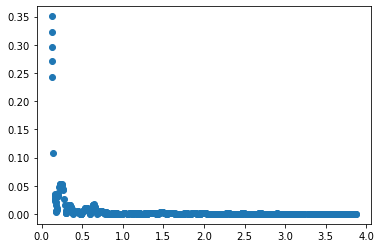

In [27]:
axisX = (IntervalTest[:,1] + IntervalTest[:,0])/2
axisY = relError

plt.plot(axisX, axisY, 'o')
print(relError)
plt.savefig('pol2_plot.pdf')  

In [28]:
startTime = timeit.default_timer()
numIntervals = 50000
power = 3
up_bound = 4.0
low_bound = 0.0
width = 0.25
Intervals, FInterval = IntervalsRandomEvenPolynomial(numIntervals, width, low_bound, up_bound, power)
model = TrainModelPolynomial(Intervals, FInterval)

relError, IntervalTest, FTest, absError = TestModelFixedPolynomial(width, low_bound, up_bound, power, model)
relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/50
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0021
Epoch 2/50
1563/1563 [==============================] - 2s 1ms/step - loss: 9.6047e-04
Epoch 3/50
1563/1563 [==============================] - 2s 1ms/step - loss: 5.6516e-04
Epoch 4/50
1563/1563 [==============================] - 2s 1ms/step - loss: 2.9861e-04
Epoch 5/50
1563/1563 [==============================] - 2s 1ms/step - loss: 1.3554e-04
Epoch 6/50
1563/1563 [==============================] - 2s 1ms/step - loss: 6.2475e-05
Epoch 7/50
1563/1563 [==============================] - 2s 1ms/step - loss: 3.2956e-05
Epoch 8/50
1563/1563 [==============================] - 2s 1ms/step - loss: 1.9598e-05
Epoch 9/50
1563/1563 [==============================] - 2s 1ms/step - loss: 1.3389e-05
Epoch 10/50
1563/1563 [==============================] - 2s 1ms/step - loss: 9.6043e-06
Epoch 11/50
1563/1563 [==============================] - 2s 1ms/step - loss: 7.3249e-06
Epoch 12/50
1563/1563 [======================

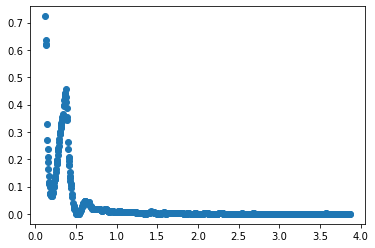

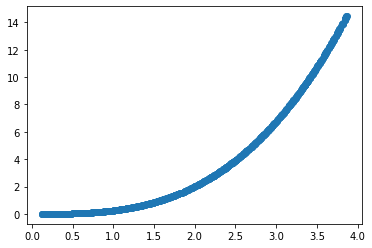

In [30]:
#some error analysis

axisX = (IntervalTest[:,1] + IntervalTest[:,0])/2
axisY = relError
plt.figure(1)
plt.plot(axisX, axisY, 'o')
plt.savefig('pol3_plot.pdf')

plt.figure(2)
plt.plot(axisX, FTest, 'o')
plt.savefig('F_plot.pdf')

In [31]:
startTime = timeit.default_timer()
numIntervals = 50000
power = 4
up_bound = 4.0
low_bound = 0.0
width = 0.25
Intervals, FInterval = IntervalsRandomEvenPolynomial(numIntervals, width, low_bound, up_bound, power)
model = TrainModelPolynomial(Intervals, FInterval)

relError, IntervalTest, FTest, absError = TestModelFixedPolynomial(width, low_bound, up_bound, power, model)
relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/50
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0099
Epoch 2/50
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0062
Epoch 3/50
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0048
Epoch 4/50
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0036
Epoch 5/50
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0026
Epoch 6/50
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0019
Epoch 7/50
1563/1563 [==============================] - 2s 1ms/step - loss: 0.0014
Epoch 8/50
1563/1563 [==============================] - 2s 1ms/step - loss: 9.7163e-04
Epoch 9/50
1563/1563 [==============================] - 2s 1ms/step - loss: 6.5895e-04
Epoch 10/50
1563/1563 [==============================] - 2s 1ms/step - loss: 4.5732e-04
Epoch 11/50
1563/1563 [==============================] - 2s 1ms/step - loss: 3.3020e-04
Epoch 12/50
1563/1563 [==============================] - 2s 1ms/step 

[4.784e-04 7.399e-04 1.243e-02 1.989e-03 1.726e-04 5.043e-04 6.177e-01
 1.764e-01 5.048e-04 3.580e-04 1.735e-03 9.951e-03 2.044e+00 3.841e-04
 9.401e-03 6.495e-04 3.812e-03 4.281e-04 3.473e+01 1.554e-02 1.172e-02
 7.904e-02 6.546e-04 1.002e-03 2.738e-03 3.596e-02 1.196e-02 5.002e-03
 4.264e-04 1.106e-02 2.898e-01 2.409e-02 4.980e-04 4.866e+00 4.010e-04
 3.926e-04 8.811e-02 9.633e-03 3.509e-04 1.200e-03 2.126e-03 2.819e-04
 2.391e-04 2.709e-03 3.240e-03 7.649e-03 2.930e-03 4.058e-04 3.795e-04
 1.121e-03 8.940e-04 1.368e-02 9.798e-04 2.427e-02 1.218e-03 1.396e+02
 8.512e-05 1.436e-03 1.677e-01 1.244e+02 1.320e-01 3.704e-02 9.106e-03
 4.391e-03 8.530e-04 1.278e-01 5.678e-03 8.989e-04 3.699e-02 2.778e-04
 1.104e-03 5.519e-04 2.401e-02 1.035e-03 3.356e-02 1.640e-03 1.071e-03
 1.621e-04 3.515e-04 4.133e-04 4.000e-04 9.508e-03 1.343e-03 1.116e-03
 4.514e-04 3.523e-02 5.412e-04 1.881e-03 1.475e-02 3.834e-02 1.237e-01
 9.388e-04 9.926e-03 1.790e-03 1.915e-01 9.685e-04 5.268e+00 3.027e-02
 1.928

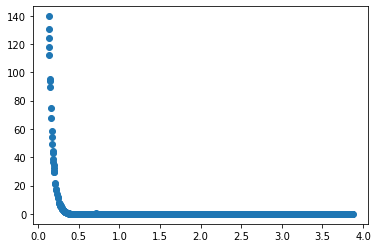

In [32]:
axisX = ((IntervalTest[:,0]) + (IntervalTest[:,1]))/2
axisY = relError

plt.plot(axisX, axisY, 'o')
print(relError)
plt.savefig('pol4_plot.pdf')  

Third kind of problem: Both length of an interval and both endpoints are aribtary
on interval [0,1]. 

In [33]:
startTime = timeit.default_timer()
up_bound = 1.0
low_bound = 0.0
points = 250
grid = np.linspace(low_bound, up_bound, num=points)
Intervals, FInterval = IntervalsRandom(points, grid)
x_val, y_val = ValidationFixed(width, low_bound, up_bound)
model = TrainModelArbitrary(Intervals, FInterval, x_val, y_val)

relError, IntervalTest, FTest = TestModelArbitrary(points, low_bound, up_bound,  model)


for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/30
973/973 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 4.3809e-04
Epoch 2/30
973/973 [==============================] - 1s 1ms/step - loss: 9.6570e-04 - val_loss: 3.3543e-04
Epoch 3/30
973/973 [==============================] - 1s 1ms/step - loss: 5.0818e-04 - val_loss: 2.0574e-04
Epoch 4/30
973/973 [==============================] - 1s 1ms/step - loss: 2.0651e-04 - val_loss: 9.1410e-05
Epoch 5/30
973/973 [==============================] - 1s 1ms/step - loss: 1.0906e-04 - val_loss: 8.7642e-05
Epoch 6/30
973/973 [==============================] - 1s 1ms/step - loss: 7.2026e-05 - val_loss: 5.2268e-05
Epoch 7/30
973/973 [==============================] - 1s 1ms/step - loss: 5.6111e-05 - val_loss: 4.1762e-05
Epoch 8/30
973/973 [==============================] - 1s 1ms/step - loss: 4.8219e-05 - val_loss: 4.0365e-05
Epoch 9/30
973/973 [==============================] - 1s 1ms/step - loss: 4.3126e-05 - val_loss: 5.8965e-05
Epoch 10/30
973/973 [===========

Same problem tested on LSTM. 

In [34]:
startTime = timeit.default_timer()
up_bound = 1.0
low_bound = 0.0
numIntervals = 10000
#grid = np.linspace(low_bound, up_bound, num=points)

Intervals, FInterval = IntervalsRandomEven(numIntervals, width, low_bound, up_bound)
IntervalsR = np.reshape(Intervals, (Intervals.shape[0], 1, Intervals.shape[1]))
FIntervalR = np.reshape(FInterval, (FInterval.shape[0], 1, 1))

x_val, y_val = ValidationFixed(width, low_bound, up_bound)
x_valR = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1]))
y_valR = np.reshape(y_val, (y_val.shape[0], 1, 1))

model = TrainModelZeroRecurrent(IntervalsR, FIntervalR, x_valR, y_valR)

relError, IntervalTest, FTest = TestModelRecurrentEven(width, low_bound, up_bound, model)
relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/20
313/313 [==============================] - 1s 4ms/step - loss: 0.0086 - val_loss: 0.0033
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 9.4026e-04 - val_loss: 3.0603e-04
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 3.4883e-04 - val_loss: 3.2512e-04
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 3.3860e-04 - val_loss: 2.9179e-04
Epoch 5/20
313/313 [==============================] - 1s 3ms/step - loss: 3.2866e-04 - val_loss: 3.2001e-04
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 3.1839e-04 - val_loss: 2.9153e-04
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 3.0821e-04 - val_loss: 2.7724e-04
Epoch 8/20
313/313 [==============================] - 1s 2ms/step - loss: 2.9728e-04 - val_loss: 2.7634e-04
Epoch 9/20
313/313 [==============================] - 1s 2ms/step - loss: 2.8653e-04 - val_loss: 2.5885e-04
Epoch 10/20
313/313 [===============

Part2. 
In the next few cells rectangles on [0,2] x [0,2] are generated and tested on rectangles of arbitary sizes on
[0,2] x [0,2]. First, number of points in the x and y direction are specified. This results in 20x20 grid. 
Subsequently, all possible combinations or rectangles on that grid is generated and used as a training set. 
After that, similar analysis to the previous problems is performed on Dense networks and LSTM+Dense networks. 

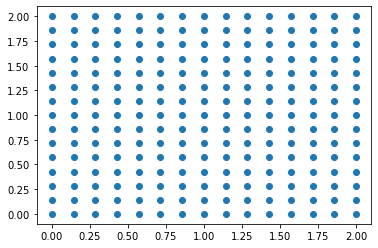

In [43]:
#generate grid an plot it
import numpy as np
import matplotlib.pyplot as plt

up_bound = 2.0
low_bound = 0.0
pointsX = 15
pointsY = 15
points = pointsX#since assuming domain is a square
numPoints = pointsX * pointsY
gridX = np.linspace(low_bound, up_bound, num=pointsX)
gridY = np.linspace(low_bound, up_bound, num=pointsY)

vert = np.zeros([numPoints, 2])
for i in range(pointsX):
    for j in range(pointsY):
        vert[i*pointsY + j, 0] = gridX[i]
        vert[i*pointsY + j, 1] = gridY[j]
        
count = 0
vertX = []
vertY = []
for i in range(numPoints):
    vertX.append(vert[i, 0])
    vertY.append(vert[i, 1])
plt.plot(vertX, vertY, 'o')

In [44]:
#the segment of code in this cell generates all possible combinations of rectangles on the grid
#def GenerateGrid:

numBoundVert = (pointsX-1) * (pointsY-1)
vertLeftDown = np.zeros([numBoundVert, 2])
vertRightUp = np.zeros([numBoundVert, 2])

for i in range(pointsX-1):
    for j in range(pointsY-1):
        vertLeftDown[i*(pointsY-1) + j, :] = vert[i*pointsY +j, :]
        vertRightUp[i*(pointsY-1) + j, :] = vert[(i+1)*pointsY + (j+1), :]
      
#formula for calculating number of rectangles in a grid from 
#https://www.geeksforgeeks.org/number-rectangles-nm-grid
#with slight adjustment based on how I am indexing
numSquares = (pointsX-1)*(pointsX) * (pointsY-1)*(pointsY) / 4 
numSquares = int(numSquares)
Squares = np.zeros([numSquares, 8])

outcount = 0
inCount = 0
totCount = 0
for i in range (numBoundVert):
    inCount = 0
    j  = i
    while(j < numBoundVert):
        
        Squares[totCount, 0] = vertLeftDown[i, 0]
        Squares[totCount, 1] = vertLeftDown[i, 1]  
        Squares[totCount, 2] = vertRightUp[j, 0]
        Squares[totCount, 3] = vertLeftDown[i, 1] 
        Squares[totCount, 4] = vertLeftDown[i, 0]
        Squares[totCount, 5] = vertRightUp[j, 1]  
        Squares[totCount, 6] = vertRightUp[j,0]
        Squares[totCount, 7] = vertRightUp[j,1]
        
        totCount += 1
        inCount += 1

        if (( (j+1) % (pointsY-1)) == 0):
            j = j + (outcount)%(pointsX-1)
           
            j = j+1
            continue 
            
        j = j+1
        
    outcount += 1
    
  

<ipython-input-45-b70c173a9390>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


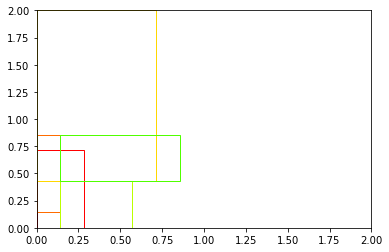

In [45]:
#in this cell some generated rectangles are plotted
#Snippet of the code below from from https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
N = 15
cmap = get_cmap(N)


#reference for plotting patches https://www.geeksforgeeks.org/matplotlib-patches-rectangle-in-python/
from matplotlib.patches import Rectangle
  

fig = plt.figure()
plt.xlim(low_bound, up_bound)
plt.ylim(low_bound, up_bound)
ax = fig.add_subplot(111)
count = 0
r = [18, 200,  600, 1500, 2023]
for i in range(5):
    
    ax.add_patch( Rectangle((Squares[r[i],0:2]),
                        Squares[r[i],6]-Squares[r[i],0], Squares[r[i], 7]-Squares[r[i],1],
                        fc ='none', 
                        color = cmap(count)))
    count += 1

In [46]:
#compute targets. In this instance: integral of a function exp(x+y) over generated rectangles
F = np.zeros(numSquares)
for i in range(numSquares):
    F[i] = ( np.exp(Squares[i,6]) - np.exp(Squares[i,0]) ) * (np.exp(Squares[i,7]) - np.exp(Squares[i,1]) )
    

In [39]:
startTime = timeit.default_timer()

#train the model
import tensorflow as tf
from keras import models
import keras.backend as K
from keras import layers
from keras import optimizers
from keras.layers import Dense
from keras.regularizers import l2
from scipy.linalg import norm
from tensorflow.keras import initializers

model = models.Sequential() 
model.add(layers.Dense(128,  kernel_initializer='normal', activation = 'relu',  input_shape=(8, )))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(1))
opt = optimizers.Adam(learning_rate=0.00008)
model.compile(loss= Integral_loss, optimizer=opt)
model.fit(Squares, F, batch_size = 32,  epochs = 30)
  

#test on random rectangles 
import random
SquaresTest = np.zeros([1000,8])
FTest = np.zeros(1000)
relError = np.zeros(1000)
absError = np.zeros(1000)

i = 0
minWidth = (up_bound - low_bound) / pointsX
minHeight = (up_bound - low_bound) / pointsY
while(i<1000):
    x1 = random.uniform(low_bound,up_bound) 
    y1 = random.uniform(low_bound,up_bound) 
    x2 = random.uniform(low_bound,up_bound) 
    y2 = random.uniform(low_bound,up_bound)
    xLeft = min(x1,x2)
    xRight = max(x1,x2)
    yDown = min(y1,y2)
    yUp = max(y1, y2)
    if( (abs(xRight-xLeft) < 10.0*minWidth) or (abs(yUp-yDown) < 10.0*minHeight) ):
        continue
    SquaresTest[i,0] = xLeft
    SquaresTest[i,1] = yDown
    SquaresTest[i,2] = xRight
    SquaresTest[i,3] = yDown
    SquaresTest[i,4] = xLeft
    SquaresTest[i,5] = yUp
    SquaresTest[i,6] = xRight
    SquaresTest[i,7] = yUp
    FTest[i] = ( np.exp(SquaresTest[i,6]) - np.exp(SquaresTest[i,0]) ) * (np.exp(SquaresTest[i,7]) - np.exp(SquaresTest[i,1]) )
    i += 1

Predicted = model.predict(SquaresTest, verbose=0)
for i in range(0,1000):
    relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 
    absError[i] = abs(Predicted[i] - FTest[i])  


relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/30
1129/1129 [==============================] - 2s 1ms/step - loss: 1.3529
Epoch 2/30
1129/1129 [==============================] - 2s 1ms/step - loss: 0.7379
Epoch 3/30
1129/1129 [==============================] - 1s 1ms/step - loss: 0.4369
Epoch 4/30
1129/1129 [==============================] - 2s 1ms/step - loss: 0.3034
Epoch 5/30
1129/1129 [==============================] - 2s 2ms/step - loss: 0.2383
Epoch 6/30
1129/1129 [==============================] - 2s 2ms/step - loss: 0.2009
Epoch 7/30
1129/1129 [==============================] - 2s 1ms/step - loss: 0.1697
Epoch 8/30
1129/1129 [==============================] - 2s 1ms/step - loss: 0.1419
Epoch 9/30
1129/1129 [==============================] - 2s 1ms/step - loss: 0.1196
Epoch 10/30
1129/1129 [==============================] - 2s 1ms/step - loss: 0.1034
Epoch 11/30
1129/1129 [==============================] - 2s 1ms/step - loss: 0.0913
Epoch 12/30
1129/1129 [==============================] - 2s 1ms/step - loss: 0.0814
E

In [47]:
Squares = np.reshape(Squares, (Squares.shape[0], 1, Squares.shape[1]))
F = np.reshape(F, (F.shape[0], 1, 1))

In [48]:
#based on  templates from https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#and https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

startTime = timeit.default_timer()
model = Sequential()
model.add( tf.keras.layers.Bidirectional(LSTM(128, input_shape=(1, 8))) ) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
opt = optimizers.Adam(learning_rate=0.00008)
model.compile(loss= Integral_loss, optimizer = opt)
model.fit(Squares, F, epochs=75, batch_size=32, verbose=1)



#test on random rectangles 
import random
SquaresTest = np.zeros([1000,8])
FTest = np.zeros(1000)
relError = np.zeros(1000)
absError = np.zeros(1000)

i = 0
minWidth = (up_bound - low_bound) / pointsX
minHeight = (up_bound - low_bound) / pointsY
while(i<1000):
    x1 = random.uniform(0,2) 
    y1 = random.uniform(0,2) 
    x2 = random.uniform(0,2) 
    y2 = random.uniform(0,2)
    xLeft = min(x1,x2)
    xRight = max(x1,x2)
    yDown = min(y1,y2)
    yUp = max(y1, y2)
    if( (abs(xRight-xLeft) < 10*minWidth) or (abs(yUp-yDown) < 10*minHeight) ):
        continue
    SquaresTest[i,0] = xLeft
    SquaresTest[i,1] = yDown
    SquaresTest[i,2] = xRight
    SquaresTest[i,3] = yDown
    SquaresTest[i,4] = xLeft
    SquaresTest[i,5] = yUp
    SquaresTest[i,6] = xRight
    SquaresTest[i,7] = yUp
    FTest[i] = ( np.exp(SquaresTest[i,6]) - np.exp(SquaresTest[i,0]) ) * (np.exp(SquaresTest[i,7]) - np.exp(SquaresTest[i,1]) )
    i += 1

SquaresTest = np.reshape(SquaresTest, (SquaresTest.shape[0], 1, SquaresTest.shape[1]))
FTest = np.reshape(FTest, (FTest.shape[0], 1, 1))    
Predicted = model.predict(SquaresTest, verbose=0)
for i in range(0,1000):
    relError[i] = abs(Predicted[i] - FTest[i]) / abs(FTest[i]) 
    absError[i] = abs(Predicted[i] - FTest[i])  

print(relError)


relError = np.asarray(relError)
for i in range(len(relError)):
    relError[i] = '%.3E' % Decimal(relError[i])
print( '%.3E' % Decimal(relError.sum()/len(relError)))
print(  '%.3E' % Decimal(max(relError)))
print( '%.3E' % Decimal(min(relError)))

modelTime = timeit.default_timer() - startTime
print("model time =", modelTime)

Epoch 1/75
345/345 [==============================] - 1s 4ms/step - loss: 2.4382
Epoch 2/75
345/345 [==============================] - 1s 4ms/step - loss: 1.7979
Epoch 3/75
345/345 [==============================] - 1s 4ms/step - loss: 1.3523
Epoch 4/75
345/345 [==============================] - 1s 4ms/step - loss: 1.1024
Epoch 5/75
345/345 [==============================] - 1s 4ms/step - loss: 0.9416
Epoch 6/75
345/345 [==============================] - 1s 4ms/step - loss: 0.8259
Epoch 7/75
345/345 [==============================] - 1s 3ms/step - loss: 0.7137
Epoch 8/75
345/345 [==============================] - 1s 4ms/step - loss: 0.5940
Epoch 9/75
345/345 [==============================] - 1s 4ms/step - loss: 0.4876
Epoch 10/75
345/345 [==============================] - 1s 4ms/step - loss: 0.4048
Epoch 11/75
345/345 [==============================] - 1s 4ms/step - loss: 0.3277
Epoch 12/75
345/345 [==============================] - 1s 4ms/step - loss: 0.2646
Epoch 13/75
345/345 [====